In [1]:
%matplotlib inline
import numpy as np
from qiskit import *
from qiskit import IBMQ
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram
from qiskit.extensions import Initialize
from qiskit_textbook.tools import random_state, array_to_latex

def list_backends():
    provider = IBMQ.get_provider("ibm-q")
    for backend in provider.backends():
        try:
            qubit_count = len(backend.properties().qubits)
        except:
            qubit_count = "simulated"
        
        print(backend.name(), "has", backend.status().pending_jobs, "qued and", qubit_count, "qubits")

def run(b, circuit):
    provider = IBMQ.get_provider("ibm-q")
    backend = provider.get_backend(b)
    job = execute(circuit, backend=backend, shots=1000)
    job_monitor(job)
    return(job)
IBMQ.load_account()

/opt/conda/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

<IPython.core.display.Math object>

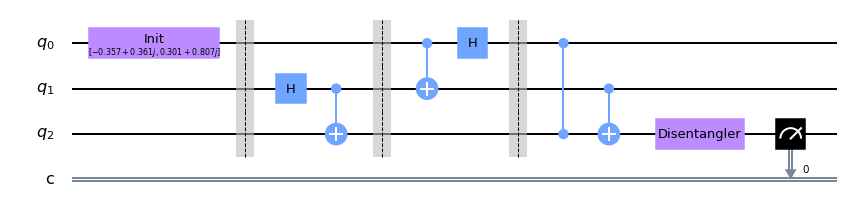

In [2]:
def create_bell_pair(qc, a, b):
    """Creates a bell pair in qc using qubits a & b"""
    qc.h(a) # Put qubit a into state |+>
    qc.cx(a,b) # CNOT with a as control and b as target

def alice_gates(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)
    
def measure_and_send(qc, a, b):
    """Measures qubits a & b and 'sends' the results to Bob"""
    qc.barrier()
    qc.measure(a,0)
    qc.measure(b,1)
    
# This function takes a QuantumCircuit (qc), integer (qubit)
# and ClassicalRegisters (crz & crx) to decide which gates to apply
def bob_gates(qc, qubit, crz, crx):
    # Here we use c_if to control our gates with a classical
    # bit instead of a qubit
    qc.x(qubit).c_if(crx, 1) # Apply gates if the registers 
    qc.z(qubit).c_if(crz, 1) # are in the state '1'
    
def new_bob_gates(qc, a, b, c):
    qc.cz(a, c)
    qc.cx(b, c)
    
# Create random 1-qubit state
psi = random_state(1)

array_to_latex(psi, pretext="|\\psi\\rangle =")
init_gate = Initialize(psi)
init_gate.label = "init"
inverse_init_gate = init_gate.gates_to_uncompute()

qc = QuantumCircuit(3,1)

# First, let's initialise Alice's q0
qc.append(init_gate, [0])
qc.barrier()

# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)
qc.barrier()
# Alice sends classical bits to Bob
new_bob_gates(qc, 0, 1, 2)

# We undo the initialisation process
qc.append(inverse_init_gate, [2])

# See the results, we only care about the state of qubit 2
qc.measure(2,0)

# View the results:
qc.draw()

In [ ]:
job = run("ibmqx2", qc)

result = job.result()
counts = result.get_counts(qc)
plot_histogram([counts])

Job Status: job is queued (9)     